## Librerias necesarias

In [171]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# sklearn utilities
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Deep Learning
from keras.models import Sequential
from keras.layers import (LSTM,
                          Dense,
                          Activation,
                          Dropout)
from keras.optimizers import Adam, SGD, RMSprop
from keras import backend as K
from keras.callbacks import EarlyStopping
from keras.utils.vis_utils import plot_model



## Descripción de los datos

Datos históricos de ventas diarias. La idea principal es pronosticar la cantidad total de productos vendidos en cada tienda para el conjunto de prueba.
___
#### Descripción de los archivos 

+ **Sales_train.csv:** Datos históricos desde Enero de 2013 hasta Octubre de 2015
+ **test.csv:** Conjunto de testeo. Con este archivo se debe pronosticar las ventas de estas tiendas y productos para Noviembre de 2015
+ **sample_submission.csv:** Un archivo de muestra para evidenciar el formato correcto de sometimiento de los resultados 
+ **items.csv:** Información complementaria sobre los productos
+ **item_categories.csv:** Información complementario sobre las categorías de los items
+ **shops.csv:** Información complementaria sobre las tiendas

#### Campos de los datos 

+ **ID:** Identificador que representa una tupla determinada por (tienda, atículo) dentro del conjunto de prueba
+ **shop_id:** Identificador único de tienda
+ **item_id:** Identificador único de producto
+ **item_categoty_id:** Identificador único de la categoría del artículo
+ **item_cnt_day:** número de productos vendidos. 
+ **item_price:** precio actual de un artículo 
+ **date:** fecha en formato dd/mm/yyyy
+ **date_block_num:** un número de mes consecutivo, utilizado por conveniencia. Enero de 2013 es 0, febrero de 2013 es 1, ..., octubre de 2015 es 33
+ **item_name:** Nombre del artículo
+ **shop_name:** Nombre de la tienda
+ **item_category_name:** nombre de la categoría del artículo

## Carga de datos

In [172]:
train = pd.read_csv("DATA/sales_train.csv", 
                    parse_dates=["date"],
                    infer_datetime_format=True,
                    dayfirst=True)
items = pd.read_csv("DATA/items.csv")
shops = pd.read_csv("DATA/shops.csv")
categories = pd.read_csv("DATA/item_categories.csv")
test = pd.read_csv("DATA/test.csv")
sample = pd.read_csv("DATA/sample_submission.csv")


## Limpieza de datos

Se remueven los datos atípicos de la base de datos 

Text(0.5, 1.0, 'Número de productos vendidos')

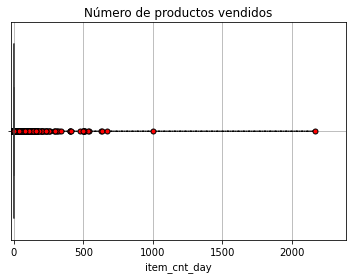

In [173]:
plt.figure()
flp = dict(marker="o",
           markerfacecolor="red",
           markersize=5,
           linestyle="--",
           markeredgecolor="black")
sns.boxplot(x=train.item_cnt_day,
            flierprops=flp,)
plt.grid(True)
plt.xlim(train.item_cnt_day.min(),
         train.item_cnt_day.max()*1.1)
plt.title("Número de productos vendidos")

Se remueven los artículos que estén arriba de un flujo de venta de 1000

In [174]:
train = train[train.item_cnt_day < 1000]

Text(0.5, 1.0, 'Precio actual del artículo')

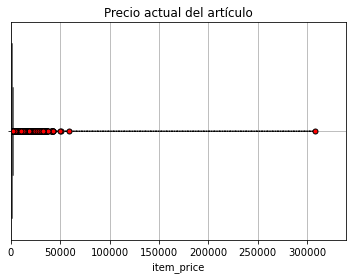

In [175]:
plt.figure()
flp = dict(marker="o",
           markerfacecolor="red",
           markersize=5,
           linestyle="--",
           markeredgecolor="black")
sns.boxplot(x=train.item_price,
            flierprops=flp,)
plt.grid(True)
plt.xlim(train.item_price.min(),
         train.item_price.max()*1.1)
plt.title("Precio actual del artículo")

Se encuentra un valor atípico arriba del precio de 300.000, tomamos como referencia el valor de 100.000 para despreciar los valores que no son comunes en la base de datos 

In [176]:
train = train[train.item_price < 100000]

Se quitan las filas en el conjunto de datos de entrenamiento en donde la cantidad de artículos vendidos  es negativa, esto no tiene sentido alguno para el propósito del análisis y se cambia por cero 

In [177]:
train.loc[train.item_cnt_day < 1, "item_cnt_day"] = 0

## Exploración de datos 

Revisión de la estadística descriptiva de los datos 

In [178]:
train.describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day
count,2.935846e+06,2.935846e+06,2.935846e+06,2.935846e+06,2.935846e+06
mean,1.456990e+01,3.300175e+01,1.019722e+04,8.907492e+02,1.244131e+00
std,9.422985e+00,1.622697e+01,6.324297e+03,1.720491e+03,2.215525e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,0.000000e+00
25%,7.000000e+00,2.200000e+01,4.476000e+03,2.490000e+02,1.000000e+00
50%,1.400000e+01,3.100000e+01,9.343000e+03,3.990000e+02,1.000000e+00
75%,2.300000e+01,4.700000e+01,1.568400e+04,9.990000e+02,1.000000e+00
max,3.300000e+01,5.900000e+01,2.216900e+04,5.920000e+04,6.690000e+02


Recuento de los diferentes valores que toma cada variable

In [179]:
train.nunique()

date               1034
date_block_num       34
shop_id              60
item_id           21806
item_price        19991
item_cnt_day        188
dtype: int64

¿cómo son las ventas a traves del tiempo?, compactamos los datos respecto de la variable "date_block_num", que es un identificador de los meses, sumando todas las ventas por cada valor único de esta variable

Text(0, 0.5, 'Número de artículos vendidos')

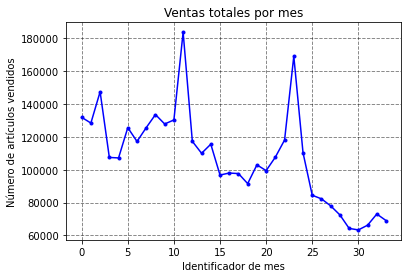

In [180]:
x_v = train.groupby("date_block_num").agg({"item_cnt_day": "sum"})
plt.title("Ventas totales por mes")
plt.plot(x_v.index, x_v["item_cnt_day"],
         "b-")
plt.plot(x_v.index, x_v["item_cnt_day"],
         "b.")

plt.grid(color='k',
         alpha=0.5,
         linestyle='dashed',
         linewidth=0.9)

plt.xlabel("Identificador de mes")
plt.ylabel("Número de artículos vendidos")

Sin embargo se puede hacer un análisis mas específico de cada año y ver un comparativo entre años

In [181]:
x_1_ano = x_v[x_v.index < 12]

x_2_ano = x_v[x_v.index >= 12]
x_2_ano = x_2_ano[x_2_ano.index < 24]

x_3_ano = x_v[x_v.index >= 24]

t = np.arange(1,13)

Text(0.5, 0, 'Mes del año')

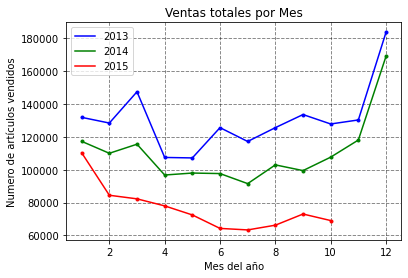

In [182]:
plt.plot(t, x_1_ano["item_cnt_day"],
         "b-",
         label = "2013")
plt.plot(t, x_1_ano["item_cnt_day"],
         "b.")

plt.plot(t, x_2_ano["item_cnt_day"],
         "g-",
         label = "2014")
plt.plot(t, x_2_ano["item_cnt_day"],
         "g.")

plt.plot(t[:-2], x_3_ano["item_cnt_day"],
         "r-",
         label = "2015")
plt.plot(t[:-2], x_3_ano["item_cnt_day"],
         "r.",)

plt.grid(color='k',
         alpha=0.5,
         linestyle='dashed',
         linewidth=0.9)

plt.legend()
plt.title("Ventas totales por Mes")
plt.ylabel("Numero de artículos vendidos")
plt.xlabel("Mes del año")

Veamos ahora un diagrama de Paretto para ver la relación entre la cantidad de unidades vendidas y precio

Text(0, 0.5, 'Número de artículos vendidos')

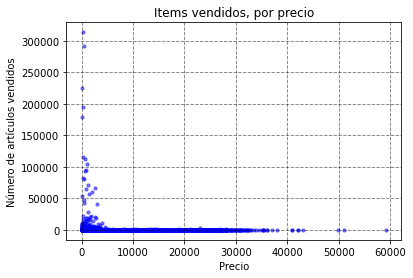

In [183]:
x_p = train.groupby("item_price").agg({"item_cnt_day": "sum"})
plt.scatter(x_p.index, x_p["item_cnt_day"],
            s=10,
            c="blue",
            marker="o",
            alpha=0.5,
            edgecolors="face")

plt.grid(color='k',
         alpha=0.5,
         linestyle='dashed',
         linewidth=0.9)

plt.title("Items vendidos, por precio")
plt.xlabel("Precio")
plt.ylabel("Número de artículos vendidos")

Se reorganizan lo datos para que se puedan ver como ventas mensuales por items, además se reorganiza la base de datos para tener solamente cuatro variables

In [184]:
df = train.groupby([train.date.apply(lambda x: x.strftime('%Y-%m')),'item_id','shop_id']).sum().reset_index()
df = df[['date','item_id','shop_id','item_cnt_day']]

In [185]:
df

,date,item_id,shop_id,item_cnt_day
0,2013-01,19,25,1.0
1,2013-01,27,1,1.0
2,2013-01,27,2,1.0
3,2013-01,27,10,1.0
4,2013-01,27,19,1.0
...,...,...,...,...
1609117,2015-10,22167,28,1.0
1609118,2015-10,22167,37,1.0
1609119,2015-10,22167,42,4.0
1609120,2015-10,22167,47,1.0


Ahora se cercan los datos en la variable número de artículos de ventas por días. Poniendo de límite el conjunto [0,20], los valores más altos que veinte se reemplazarán por veinte y los menores de cero, se pondrán como cero

In [186]:
df["item_cnt_day"].clip(0.,20.,inplace=True)

Ahora lo que se quiere hacer es agrupar los datos, teniendo como referencia las columnas de identificador de itmes(**item_id**) y identificador de tienda (**shop_id**). para poder tener explicitamente el numero de artículos vendidos a traves del tiempo de cada item en cada tienda

In [187]:
df = df.pivot_table(index=['item_id','shop_id'], columns='date',values='item_cnt_day',fill_value=0).reset_index()

In [188]:
df

date,item_id,shop_id,2013-01,2013-02,2013-03,2013-04,2013-05,2013-06,2013-07,2013-08,...,2015-01,2015-02,2015-03,2015-04,2015-05,2015-06,2015-07,2015-08,2015-09,2015-10
0,0,54,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,55,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,54,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,54,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,54,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
424118,22168,12,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
424119,22168,16,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
424120,22168,42,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
424121,22168,43,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Inicialemnte se considera el modelo más simple, para esto se eliminan los datos categóricos, solamentes se quiere tener series de tiempo sin nungún tipo de procesamiento

In [189]:
df = df.drop(labels=["item_id","shop_id"],axis=1)

In [190]:
df

date,2013-01,2013-02,2013-03,2013-04,2013-05,2013-06,2013-07,2013-08,2013-09,2013-10,...,2015-01,2015-02,2015-03,2015-04,2015-05,2015-06,2015-07,2015-08,2015-09,2015-10
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
424118,1,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
424119,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
424120,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
424121,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Se recalculan los campos de precio para tener el promedio de precio mensual por atículo, por tienda. Es un propuesta para reducir la complejidad del modelo

In [191]:
# scaler = MinMaxScaler(feature_range=(0,1))
# train["item_price"] = scaler.fit_transform(train["item_price"].values.reshape(-1,1))
df2 = train.groupby([train.date.apply(lambda x: x.strftime('%Y-%m')),'item_id','shop_id']).mean().reset_index()
df2 = df2[['date',
             'item_id',
             'shop_id',
             'item_price']].pivot_table(index=['item_id','shop_id'],
                                        columns='date',
                                        values='item_price',
                                        fill_value=0).reset_index()
df2 = df2.drop(labels=["item_id","shop_id"], axis =1)

In [192]:
df2

date,2013-01,2013-02,2013-03,2013-04,2013-05,2013-06,2013-07,2013-08,2013-09,2013-10,...,2015-01,2015-02,2015-03,2015-04,2015-05,2015-06,2015-07,2015-08,2015-09,2015-10
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
424118,799.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,799.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
424119,0.0,799.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
424120,0.0,799.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
424121,0.0,0.0,798.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [193]:
df2.to_csv("df.csv")

Se designan los conjuntos de entrenamiento y validación

In [194]:
y_train = df["2015-10"]
x_sales = df.drop(labels=["2015-10"], axis=1)
x_prices = df2.drop(labels=["2015-10"], axis=1)

Se redimenzionaliza para poder pasarla al modelo de la red neuronal 



In [195]:
x_sales = x_sales.values.reshape((x_sales.shape[0], x_sales.shape[1], 1))
x_prices= x_prices.values.reshape((x_prices.shape[0], x_prices.shape[1], 1))

por ultimo se compactifica en una matriz multidimensional las series temporales, de esta manera se tiene el conjunto de entrenamiento 

In [196]:
X = np.append(x_sales, x_prices, axis=2)
y = y_train
print("Tamaño datos entrenamiento: ",X.shape)
print("Tamaño datos objetivo: ",y.shape)

Tamaño datos entrenamiento:  (424123, 33, 2)
Tamaño datos objetivo:  (424123,)


In [197]:
X_train, X_val, y_train, y_val = train_test_split(X,
                                                  y,
                                                  test_size=0.2,
                                                  random_state=11,
                                                  shuffle=False) 

print("Tamaño de entrenamiento: ",np.shape(X_train))
print("Tamaño de validacion: ",X_val.shape)
print("Tamaño objetivo entrenamiento: ",y_train.shape)
print("Tamaño objetivo validación: ",y_val.shape)
    

Tamaño de entrenamiento:  (339298, 33, 2)
Tamaño de validacion:  (84825, 33, 2)
Tamaño objetivo entrenamiento:  (339298,)
Tamaño objetivo validación:  (84825,)


### Construcción de la Red Neuronal



In [209]:
modelo = Sequential()
modelo.add(LSTM(16, 
                input_shape=(X.shape[1], X.shape[2]), 
                return_sequences=True))
modelo.add(Dropout(0.5))
modelo.add(LSTM(32))
modelo.add(Dropout(0.5))
modelo.add(Dense(32))
modelo.add(Dense(1))

modelo.compile(optimizer="adam", 
               loss="mse",
               metrics=["mse"])

print(modelo.summary())




Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_10 (LSTM)               (None, 33, 16)            1216      
_________________________________________________________________
dropout_10 (Dropout)         (None, 33, 16)            0         
_________________________________________________________________
lstm_11 (LSTM)               (None, 32)                6272      
_________________________________________________________________
dropout_11 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_22 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_23 (Dense)             (None, 1)                 33        
Total params: 8,577
Trainable params: 8,577
Non-trainable params: 0
____________________________________________________

Definición de los parámetros de la red

In [200]:
LSTM_PARAM = {"batch_size": 128,
              "verbose": 1,
              "epochs": 10}

Definición de parada temprana para evitar sobrecostos computacionales

In [201]:
callback = [EarlyStopping(monitor="val_loss",
                          min_delta=0.01,
                          patience=3,
                          mode="auto")]

Entrenamiento de la red

In [210]:
hist = modelo.fit(X_train,
                  y_train,
                  validation_data=(X_val,y_val),
                  callbacks=callback,
                  **LSTM_PARAM)

Epoch 1/10
2651/2651 [==============================] - 162s 61ms/step - loss: 0.5976 - mse: 0.5976 - val_loss: 0.4760 - val_mse: 0.4760
Epoch 2/10
2651/2651 [==============================] - 159s 60ms/step - loss: 0.5639 - mse: 0.5639 - val_loss: 0.4761 - val_mse: 0.4761
Epoch 3/10
2651/2651 [==============================] - 161s 61ms/step - loss: 0.5413 - mse: 0.5413 - val_loss: 0.4643 - val_mse: 0.4643
Epoch 4/10
2651/2651 [==============================] - 164s 62ms/step - loss: 0.5265 - mse: 0.5265 - val_loss: 0.4676 - val_mse: 0.4676
Epoch 5/10
2651/2651 [==============================] - 177s 67ms/step - loss: 0.5357 - mse: 0.5357 - val_loss: 0.4732 - val_mse: 0.4732
Epoch 6/10
2651/2651 [==============================] - 215s 81ms/step - loss: 0.5325 - mse: 0.5325 - val_loss: 0.4693 - val_mse: 0.4693


In [211]:
test = test.drop(labels = )
pred = modelo.predict(X_val)

In [212]:
best = np.argmin(hist.history["val_loss"])
print("Mejor época: ",best)
print("Puntaje entrenamiento: {}, Puntaje Validación: {}".format(hist.history["loss"][best],hist.history["val_loss"][best]))

Mejor época:  2
Puntaje entrenamiento: 0.5412536263465881, Puntaje Validación: 0.46426278352737427


In [213]:
print("Salida para la competencia")
submission = pd.DataFrame(pred,columns=['item_cnt_month'])
submission.to_csv('submission.csv',index_label='ID')

Salida para la competencia


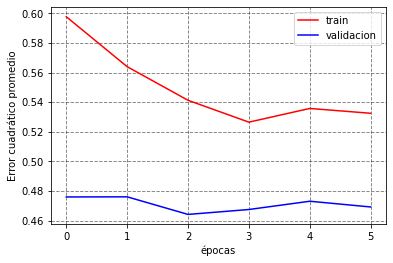

In [214]:
plt.plot(hist.history['loss'], "r-", label='train')
plt.plot(hist.history['val_loss'], "b-", label='validacion')
plt.xlabel("épocas")
plt.ylabel("Error cuadrático promedio")
plt.grid(color='k',
         alpha=0.5,
         linestyle='dashed',
         linewidth=0.9)
plt.legend()


In [215]:
submission

,item_cnt_month
0,0.117217
1,-0.007915
2,0.111012
3,-0.012862
4,-0.013088
...,...
84820,-0.012809
84821,-0.013155
84822,-0.013155
84823,-0.013114
